# Dog Breed Identification
Determine the breed of a dog in an image

### Dataset
This data is part of Kaggle Playground Prediction Competition of 2017.

In this playground competition, the candidates were provided with a strictly canine subset of ImageNet in order to practice fine-grained image categorization. The dataset had 120 breeds of dogs and a limited number training images per class. Each image has a filename that is its unique id. The dataset comprises 120 breeds of dogs. The goal of the competition is to create a classifier capable of determining a dog's breed from a photo.

File descriptions
- train.zip - the training set, you are provided the breed for these dogs
- test.zip - the test set, you must predict the probability of each breed for each image
- sample_submission.csv - a sample submission file in the correct format
- labels.csv - the breeds for the images in the train set

Acknowledgments

Kaggle authorities extend their gratitude to the creators of the Stanford Dogs Dataset, which made this competition possible: Aditya Khosla, Nityananda Jayadevaprakash, Bangpeng Yao, and Fei-Fei Li.

In [1]:
import tensorflow as tf
print (tf.__version__)

2.3.0


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
project_path = '/content/drive/My Drive/DogBreed_Classification/'

In [5]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip','r') as z:
  z.extractall()

In [6]:
from zipfile import ZipFile
with ZipFile(project_path+'labels.csv.zip','r') as z:
  z.extractall()

In [4]:
labels = pd.read_csv('labels.csv')
labels.head()

,id,breed
0,000bec180eb18c7604dcecc8fe0dba07,boston_bull
1,001513dfcb2ffafc82cccf4d8bbaba97,dingo
2,001cdf01b096e06d78e9e5112d419397,pekinese
3,00214f311d5d2247d5dfe4fe24b2303d,bluetick
4,0021f9ceb3235effd7fcde7f7538ed62,golden_retriever


In [5]:
img_rows=224
img_cols=224
channels=3

In [6]:
from tqdm import tqdm
import cv2
features=[]
label=[]

for f, img in tqdm(labels.values): #f for image id, img for dog breed
  train_img = cv2.imread('./train/{}.jpg'.format(f),1) #0 for grayscale & 1 for rgb
  train_img_resize = cv2.resize(train_img, (img_rows,img_cols))
  features.append(train_img_resize)
  label.append(img)


100%|██████████| 10222/10222 [00:31<00:00, 327.10it/s]


english_setter


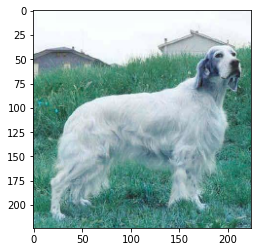

In [10]:
plt.imshow(features[180])
print (label[180])

In [ ]:
labels['breed'].value_counts()

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
komondor                 67
golden_retriever         67
brabancon_griffon        67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

In [11]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
label = encoder.fit_transform(label)

In [12]:
label[180]

40

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(features, label, test_size=0.3, stratify=label, random_state=42)

In [14]:
x_train=np.array(x_train)
x_test=np.array(x_test)

78


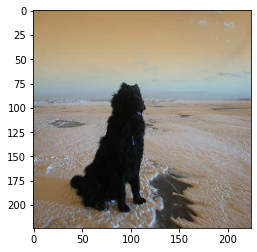

In [16]:
plt.imshow(x_train[0])
print (y_train[0])

In [27]:
print('Trainig features:',x_train.shape)
print('Testing features:',x_test.shape)

Trainig features: (7155, 224, 224, 3)
Testing features: (3067, 224, 224, 3)


In [28]:
print('Trainig labels:',y_train.shape)
print('Testing labels:',y_test.shape)

Trainig labels: (7155,)
Testing labels: (3067,)


In [17]:
datagen= tf.keras.preprocessing.image.ImageDataGenerator(#preprocessing_function=preprocess_input,
                                                         rescale=1./255,
                                                         width_shift_range=0.2,
                                                         height_shift_range=0.2,
                                                         rotation_range=30,
                                                         shear_range=0.2,
                                                         zoom_range=0.3,
                                                         horizontal_flip=True,
                                                         vertical_flip=True)

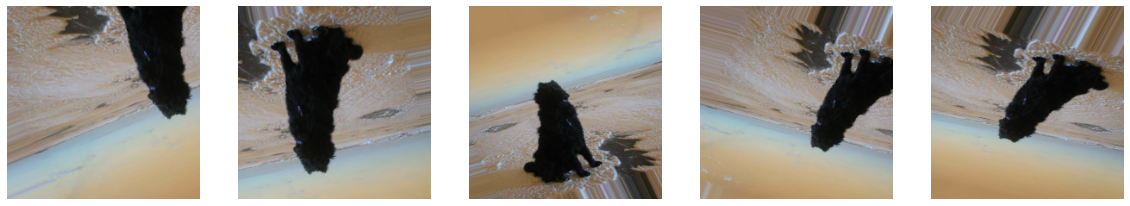

In [18]:
from matplotlib import pyplot as plt
plt.figure(figsize=(20,10))
gen = datagen.flow(x_train[0:1], batch_size=1)
for i in range(1, 6):
    plt.subplot(1,5,i)
    plt.axis("off")
    plt.imshow(gen.next().squeeze())
    plt.plot()
plt.show()

In [19]:
y_train = tf.keras.utils.to_categorical(y_train, 120)
y_test = tf.keras.utils.to_categorical(y_test, 120)

In [20]:
train_generator = datagen.flow(x_train,y_train,batch_size=64,seed=42)
#val_generator = datagen.flow(x_test,y_test,batch_size=64,seed=42)

In [21]:
#Clear any previous model from memory
tf.keras.backend.clear_session()

#Initialize model
model = tf.keras.models.Sequential()

#normalize data
model.add(tf.keras.layers.Conv2D(96, kernel_size=11, activation='relu',strides=4,input_shape=(img_rows,img_cols,channels)))
model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
model.add(tf.keras.layers.Conv2D(256, kernel_size=5, activation='relu',padding='same'))
model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
model.add(tf.keras.layers.Conv2D(384, kernel_size=3, activation='relu',padding='same'))
model.add(tf.keras.layers.Conv2D(384, kernel_size=3, activation='relu',padding='same'))
model.add(tf.keras.layers.Conv2D(256, kernel_size=3, activation='relu'))
model.add(tf.keras.layers.MaxPool2D(pool_size=3,strides=2))
#Add Dense Layers after flattening the data
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(4096, activation='relu'))
#tf.keras.layers.Dropout(0.5)
model.add(tf.keras.layers.Dense(4096, activation='relu'))
#tf.keras.layers.Dropout(0.5)
#Add Output Layer
model.add(tf.keras.layers.Dense(120, activation='softmax'))
#Model Summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 256)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 12, 12, 384)       885120    
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 12, 12, 384)       1327488   
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 10, 10, 256)       8

In [22]:
#Specify Loass and Optimizer
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [23]:
model_checkpoint=tf.keras.callbacks.ModelCheckpoint('dogbreed_cnn.h5', #where to save the model
                                                    save_best_only=True, 
                                                    monitor='val_acc', 
                                                    mode='max',
                                                    min_delta=0.001,
                                                    patience=5,
                                                    verbose=1)
model_es=tf.keras.callbacks.EarlyStopping(monitor='val_acc',min_delta=0.001,patience=5,mode='max',verbose=1)
model_lr=tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.1,patience=5,verbose=1,mode='auto',min_delta=0.0001)

In [25]:
history = model.fit(train_generator,
                    epochs=10,
                    steps_per_epoch= len(x_train)//64,  #Number of training images//batch_size
                    validation_data=(x_test,y_test),
                    #validation_data=val_generator,
                    #validation_steps = len(x_test)//64, #Number of test images//batch_size
                    callbacks = [model_checkpoint, model_es, model_lr])

Epoch 1/10
111/111 [==============================] - 67s 605ms/step - loss: 4.7866 - accuracy: 0.0103 - val_loss: 4.7812 - val_accuracy: 0.0114
Epoch 2/10
111/111 [==============================] - 66s 595ms/step - loss: 4.7828 - accuracy: 0.0106 - val_loss: 4.7786 - val_accuracy: 0.0114
Epoch 3/10
111/111 [==============================] - 66s 596ms/step - loss: 4.7810 - accuracy: 0.0106 - val_loss: 4.7769 - val_accuracy: 0.0124
Epoch 4/10
111/111 [==============================] - 66s 594ms/step - loss: 4.7798 - accuracy: 0.0111 - val_loss: 4.7763 - val_accuracy: 0.0124
Epoch 5/10
111/111 [==============================] - 66s 597ms/step - loss: 4.7799 - accuracy: 0.0123 - val_loss: 4.7769 - val_accuracy: 0.0124
Epoch 6/10
111/111 [==============================] - 66s 597ms/step - loss: 4.7793 - accuracy: 0.0121 - val_loss: 4.7761 - val_accuracy: 0.0124
Epoch 7/10
111/111 [==============================] - 66s 595ms/step - loss: 4.7790 - accuracy: 0.0124 - val_loss: 4.7760 - val_ac

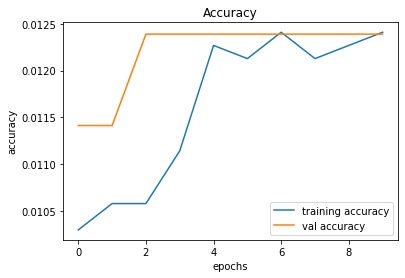

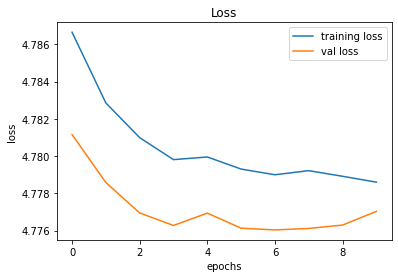

In [26]:
plt.figure(0)
plt.plot(history.history['accuracy'], label='training accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()

plt.figure(1)
plt.plot(history.history['loss'], label='training loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()